# AIC-5102B Lab 2 / Text classification

The aim of this lab is to use LDA and its kernelized version to perform text classification. You should work by pairs, as I explained by email.

## 0. Submission instructions

Drop a ZIP archive of your working directory on https://mvproxy.esiee.fr by October 5th, 23:59. Late deliveries will be penalized 1pt/day. As you are working by pairs, any of you can submit for both; moreover, the last submission overwrites the former ones.

Your working directory should contain:
- This notebook (lab2.ipynb), filled with answers to the questions ;
- and a *local* copy of the text articles or CSV files you are working with, which you should access to relatively and not absolutely. 

Please pay attention to the latter point. Code like
```
csv.reader('C:\Users\Yoyodyne\My Documents\AIC-5102B\Lab2 Text Classification/dataset.csv')
```

should be banned, and replaced by
```
csv.reader('dataset.csv')
```
or
```
csv.read('./data/class1.csv')
csv.read('./data/class2.csv')
```

I should be able to run your code on *Linux* without modifying the 'C:\Users\Yoyodyne\My Documents\AIC-5102B', which I don't have access to, nor changing anything else when I run your notebook. You must also stick to NLTK, and packages I include myself in the following code blocks, and nothing else.


## 1. Setup


You are free to choose the working dataset you wish to work with from Kaggle amongnst the following :
- Ecommerce Text Classification
- BBC Full Text Document Classification
- Text Classification on Emails
- Spam Text Message Classification

See https://www.kaggle.com/datasets?search=text+classification

Moreover, to alleviate the problem we will work with only 2 classes, so you will also have to choose 2 classes amongst those offered by your dataset.

You should choose a dataset which contains documents which are long enough, otherwise it is unlikely that the specialized kernel of part 4 will help. Tweets, in particular, are discouraged for that reason. If you wish to use another dataset that those mentioned above, simply ask me for validation.

Which dataset and classes did you chose ? Copy the related files to your working directory.

## 2. Text vectorization

The following functions :
- extract the vocabulary from row #5 (that number is arbitrary) of the specified CSV file 
- build the document-term matrix by reading again the same CSV file

Adapt them, so that they fit your dataset and produce a D-T matrix in the end.

Please note that:
- the tokenization method used is wordpunct_tokenize(), which may not be optimal. You may call something different in case you find really too much garbage in your resulting vocabulary.
- there are two "if" tests in dtmat_from_file which appear unnecessary so far. They are, indeed, because the test samples may include unseen words, which would generate out-of-bounds index. So unseen words are just ignored.
- you may also want to lemmatize. 

In [1]:
import csv
import nltk
import numpy as np
import sys


def voc_from_csv(csvfile):
    nlines=0
    voc=[]
    with open(csvfile, errors='ignore') as file:
        reader=csv.reader(file, delimiter=',')
        for row in reader:
            nlines=nlines+1
            voc.extend(nltk.wordpunct_tokenize(row[1]))
    voc=sorted(set(voc))        
    return voc,nlines

def dtmat_from_csv(csvfile):
    voc,rows=voc_from_csv(csvfile)
    cols=len(voc)
    mat=np.zeros((rows,cols))
    d=0
    with open(csvfile,  errors='ignore') as file:
        reader=csv.reader(file, delimiter=',')
        for row in reader:
            w= nltk.wordpunct_tokenize(row[1])
            X=np.searchsorted(voc,w,side='left')            
            for i in range(0,len(w)):
                if (X[i] < cols):
                    if (w[i] == voc[X[i]]):
                        mat[d][X[i]]+=1
            d=d+1
    return mat


### Question 1 

Run dtmat_from_csv on one of your sample dataset. Examine the resulting matrix. How many times does it happen that a given word is seen only once (possibly twice) in your training set ? Give a few lines which show this below.

<font color="blue">
Before creating the DT-Mat from the corpus, we must create a subset of data for the study. Indeed, in the default datasets, there are more than two classes and too much document. Thus, we must choose which classes we want to keep and delete all the others. Also, we must randomly remove some documents in the created subset.<br/>
Also, to be able to train some models, we must extract the classes of each document into a new array that will be used as targets. 
</font>

In [2]:
types = set(())
with open('dataset.csv', errors='ignore') as file:
    reader = csv.reader(file, delimiter=',')
    for row in reader:
        types.add(row[0])
print(types)

{'Household', 'Clothing & Accessories', 'Electronics', 'Books'}


<font color="blue">
We notice that there are four classes in the whole dataset. We will only keep two. In our case, we chose to keep the texts talking about 'Household' and 'Books'. The 'Clothing & Accesories' and 'Electronics' topics are removed from the study dataset.
</font>

In [3]:
import pandas as pd
df = pd.read_csv('dataset.csv')
# Only keeps Household and Books classes
df.columns = ['Class', 'Text']
df = df.drop(df[df.Class == 'Clothing & Accessories'].index)
df = df.drop(df[df.Class == 'Electronics'].index)

# Discard data to avoid too long computation time
remove_n = 30000
drop_indices = np.random.choice(df.index, remove_n, replace=False)
df_subset = df.drop(drop_indices)
classes = df_subset["Class"].reset_index()

total = df_subset.shape[0]
class1 = df_subset[df.Class=='Household'].shape[0]
class2 = df_subset[df.Class=='Books'].shape[0]
print('Total size: ', total,'\nClass 1 size: ',class1,'\nClass 2 size: ', class2)

Total size:  1132 
Class 1 size:  683 
Class 2 size:  449


/tmp/ipykernel_13479/2694738220.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  class1 = df_subset[df.Class=='Household'].shape[0]
/tmp/ipykernel_13479/2694738220.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  class2 = df_subset[df.Class=='Books'].shape[0]


In [4]:
df_subset.to_csv('Wdataset.csv', index=False,header=False)
mat = dtmat_from_csv('Wdataset.csv')
pd.DataFrame(mat).shape

(1132, 19403)

### Question 2

Suppose we use ordinary LDA to separate positive from negative samples, computed by voc_from_csv(). What will be the effect of an increasing number of "seen only once" words :
- on the memory complexity of the solution ?
- on the solution itself ?

Write your answer below, either in plain language or using LaTeX notation for formulas if you prefer. This question is purely theoretical and does not require any programming.

<font color='blue'>
<h3> Answer: </h3>  

Increasing seen only words will increase the memory complexity of the solution. Indeed, these words are not interesting in terms of results since they appear only once but some space must be allocated to them. We can't build a model depending on them. Having such words will reduce effectiveness of our model.

In LDA, unique words can either lead to the easy classification in some classes, or to misclassification if the unique word is found in the testing phase and has never seen in training.
</font>

### Question 3

No matter what your answer to question 2 is, add boolean parameter to voc_from_csv(), say "purge", so that when "purge" is True, the "only seen once" words are *not* included in the vocabulary. There is no need to modify dtmat_from_csv(),which has already been written to take this into account, except from the call to voc_from_csv().
Change the block below accordingly:

In [5]:
def dtmat_from_csv(csvfile, purge=False):
    voc,rows=voc_from_csv(csvfile)
    cols=len(voc)
    mat=np.zeros((rows,cols))
    d=0
    with open(csvfile,  errors='ignore') as file:
        reader=csv.reader(file, delimiter=',')
        for row in reader:
            w= nltk.wordpunct_tokenize(row[1])
            X=np.searchsorted(voc,w,side='left')            
            for i in range(0,len(w)):
                if (X[i] < cols):
                    if (w[i] == voc[X[i]]):
                        mat[d][X[i]]+=1
            d=d+1
    # Parameter to clean all rare values
    if purge:
        df = pd.DataFrame(mat)
        print("Before purge: ", df.shape)
        column_sum = df.sum(axis=0)
        selected_columns = [col for col in df.columns if column_sum[col] >= 2]
        df = df[selected_columns]
        mat = df.to_numpy()
    return mat

In [6]:
mat = dtmat_from_csv('Wdataset.csv', purge=True)
pd.DataFrame(mat).shape

Before purge:  (1132, 19403)


(1132, 10347)

## 3. Ordinary LDA

### Question 4

Write an lda(X1,X2) function which computes and returns the direction predicted by the ordinary LDA given samples X1 and X2, which should be passed as matrices of row vectors. The function should return:
- $\boldsymbol{u}$, the optimal direction
- and $s$, the abscissa of the hyperplane (the linear discriminant) on $\boldsymbol{u}$ which optimally separates the data assuming they are normally distributed after their projection on $\boldsymbol{u}$


In [7]:
def lda(X1,X2):
    # Means 
    mean_X1 = np.mean(X1, axis=0)
    mean_X2 = np.mean(X2, axis=0)
    # Variance-covariance matrices
    Sw_X1 = np.cov(X1, rowvar=False, bias=True)
    Sw_X2 = np.cov(X2, rowvar=False, bias=True)
    Sw = Sw_X1 + Sw_X2
    # Directional vector and abscissa
    u = np.linalg.solve(Sw, mean_X1 - mean_X2) # Solves W⁻¹.(m1-m2)
    s = (u.dot(mean_X1) + u.dot(mean_X2)) / 2 # Get the abscissa
    return u, s

### Question 5

Test your function on a toy sample. Count how many points are correcly classified. You may use/extend/modify the following piece of code:

In [8]:
import matplotlib.pyplot as plt

def render(X1,X2,u,s,ax,fig):
    # Projections on the optimal direction u
    y1 = X1.dot(u)
    y2 = X2.dot(u)
    threshold = (s + y1.mean() + y2.mean())/3 # Class boundary
    # Misclassified values
    errors = 0
    if np.mean(y1) < threshold:
        errors += np.sum(y1 > threshold)
        errors += np.sum(y2 < threshold)
    else:
        errors += np.sum(y1 < threshold)
        errors += np.sum(y2 > threshold)
    # Visualization
    ax.scatter(y1, [-1] * len(X1), label='Class 1', marker='o', color='blue')
    ax.scatter(y2, [1] * len(X2), label='Class 2', marker='x', color='red')
    ax.plot([threshold]*2, [-1, 1], 'g--', label='Decision boundary')
    #fig.legend()

    score = errors*100/(y1.size + y2.size)
    print("Abscissa of the boundary: ", threshold)
    print("A total of ", errors, " points are misclassified (",score,"%)")

Abscissa of the boundary:  -1.1188420642432488
A total of  0  points are misclassified ( 0.0 %)


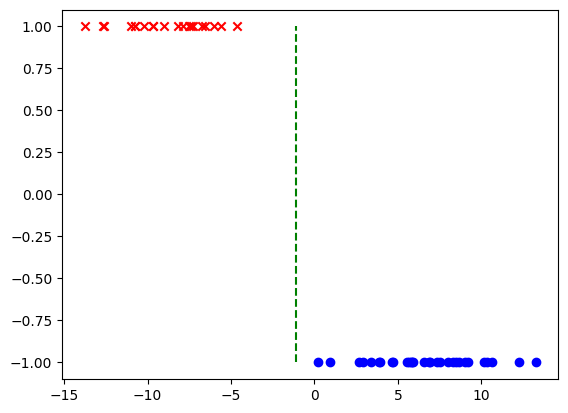

In [9]:
X1=np.random.multivariate_normal([1,2], np.identity(2),30)
X2=np.random.multivariate_normal([-3,0], 0.5*np.identity(2),20)
u,s = lda(X1,X2)

fig,ax = plt.subplots()
render(X1,X2,u,s,ax,fig)

<font color="blue">
This kind of algorithm performs relatively well on normally distributed data. Thus, over 50 samples, we obtain at most 2 or 3 misclassified values. 
</font>

### Question 6

Test the same function on your text classes. For at least one of them (most likeley, the lightest), you should normally have a problem. Why ? Add some code to your function to fix it.

In [10]:
df = pd.DataFrame(mat)
X1 = df[classes["Class"]=="Household"]
X2 = df[classes["Class"]=="Books"]
u,s = lda(X1,X2)
fig,ax = plt.subplots()
render(X1,X2,u,s,ax,fig)

LinAlgError: Singular matrix

<font color="blue">
If we try to apply the LDA directly on our DT-Mat, we obtain a SingularMatrix error. It is due to a dimensionality problem leading to non inversible covariance matrices. There are several ways to deal with this issue, we retained two, a clean version and a handmade one:
<ul>
    <li>Reduce dimensionality of the dt-mat by using simple vector decomposition to projet data into a smaller space, we will call this SVD_LDA</li>
    <li>Drop columns whose covariance are under a specific threshold. It leads to inversible covariance matrices and make us able to compute the LDA. We called this method CUSTOM_LDA</li>
</ul>
Another solution would have been to add a small dynamic robustness offset as in the KFDA method. Adding this offset results in creating some errors but it fixes the SingularMatrix error.<hr/>
Before reducing the dimensionality, it would be a good thing to normalize the DT-Mat by using the TFIDF function. We can use the code from the Lab1
</font>

In [15]:
# Code from Lab1
def tf(dtmat):
    return np.log(1+dtmat)
    
def idf(dtmat):
    N = dtmat.shape[1]
    df = pd.DataFrame(dtmat)
    exists = lambda x : 1 if x > 0 else 0
    res = df.applymap(exists) # If term appears in document replace by 1, else replace by 0
    nt = res.sum(axis=1) # Number of documents in which each term appears
    return np.tile(np.log((N+1)/(1+nt)).to_numpy(), (N, 1)).T # Repeat the vector in order to have the good dimensions

def tfidf_dtmat(dtmat):
    return tf(dtmat)*idf(dtmat)

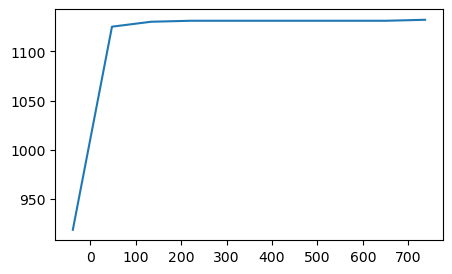

In [14]:
from scipy import stats
import matplotlib.pyplot as plt

# Displays impact of singular values to keep those who explains the best the corpus
U, sigma, V = np.linalg.svd(tfidf_dtmat(mat), full_matrices=True)

res = stats.cumfreq(sigma)
x = res.lowerlimit + np.linspace(0, res.binsize*res.cumcount.size,
                                 res.cumcount.size)
fig = plt.figure(figsize=(5,3))
plt.plot(x, res.cumcount)

<font color="blue">
<h3>SVD LDA</h3><br/>
We reduce the dimensionality of the TFIDF matrix with the SVD algorithm before computing the optimal vector and it's abscissa with the LDA. In our case, we achieve pretty good results by deleting the first thousand of singular values and keeping only the last 132.
</font>

In [17]:
def svd_reduce(X,dimension=100):
    U, sigma, V = np.linalg.svd(tfidf_dtmat(X), full_matrices=True)
    sigmatild = np.diag(sigma[dimension:])
    return np.dot(U[:,dimension:],sigmatild)

In [18]:
def svd_lda(X,y):
    A = svd_reduce(X,dimension=1000)
    df = pd.DataFrame(A)
    X1 = df[y=="Household"]
    X2 = df[y =="Books"]
    u,s = lda(X1,X2)
    return X1,X2,u,s

<font color="blue">
<h3>Custom LDA</h3><br/>
The principle of this algorithm is to compute the variances of the words of both classes. If for any of these classes, a word has a variance under the threshold, we delete it from both classes. After this, step we can compute the LDA without having any error.
</font>

In [19]:
def custom_lda(tfidf_dtmat,y):
    df = pd.DataFrame(tfidf_dtmat)
    X1 = df[y=="Household"]
    X2 = df[y =="Books"]
    # Checks for words whose variances are under the threshold
    var1 = np.var(X1,axis=0)
    var2 = np.var(X2,axis=0)
    # If either one of the two variance is under, keeps the index in memory to remove after
    var = var1*var2
    remove_ind = np.where(var <= 0.02)[0] # CHANGE VARIANCE THRESHOLD TO IMPROVE CLASSIFICATION
    # Combine the new two classes
    X1 = pd.DataFrame(X1).drop(remove_ind, axis=1) # Removes 
    X2 = pd.DataFrame(X2).drop(remove_ind, axis=1) # Removes 
    u,s = lda(X1,X2)
    return X1,X2,u,s

<font color="blue">
<h3>Rendering and comparison</h3>
</font>

/tmp/ipykernel_13382/450833346.py:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  res = df.applymap(exists) # If term appears in document replace by 1, else replace by 0
/tmp/ipykernel_13382/450833346.py:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  res = df.applymap(exists) # If term appears in document replace by 1, else replace by 0


Abscissa of the boundary:  -0.019570804174148373
A total of  453  points are misclassified ( 40.01766784452297 %)


/tmp/ipykernel_13382/450833346.py:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  res = df.applymap(exists) # If term appears in document replace by 1, else replace by 0


Abscissa of the boundary:  4.643528661988289
A total of  14  points are misclassified ( 1.2367491166077738 %)


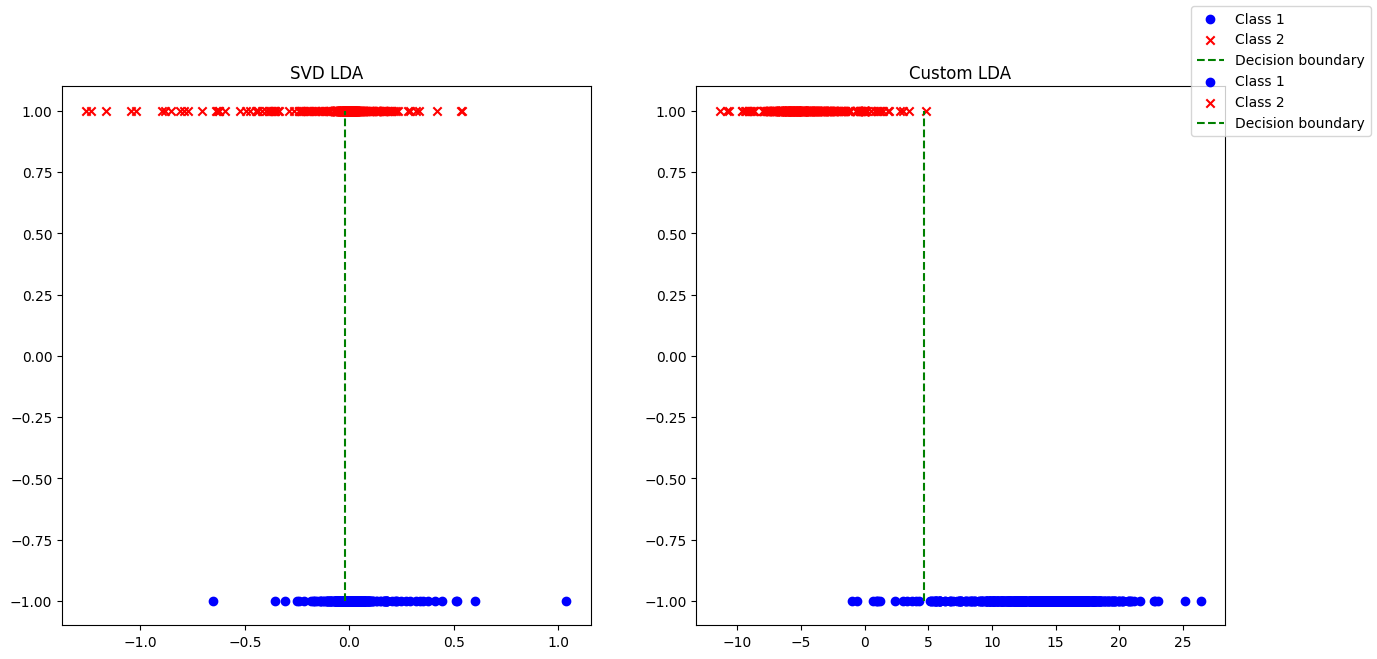

In [20]:
# Figure creation
fig,(ax1,ax2) = plt.subplots(1,2, figsize=(15,7))
ax1.set_title("SVD LDA")
ax2.set_title("Custom LDA")

# LDA w/ SVD to fix singular matrix
X1,X2,u,s = svd_lda(tfidf_dtmat(mat),classes["Class"])
render(X1,X2,u,s,ax1,fig)
# LDA w/ custom method to fix singular matrix
X3,X4,u2,s2 = custom_lda(tfidf_dtmat(mat),classes["Class"])
render(X3,X4,u2,s2,ax2,fig)

fig.legend()

<font color="blue">
We notice that we achieve far better results with the custom LDA than with the SVD LDA. However, this method will have some issues when kernelizing the LDA and increasing the dimensionality of the results. Indeed, we delete too few dimensions and then 
</font>

## 4. Kernelized LDA

The kernelized version of LDA is implemented as a kfda package. Its homepage is here: https://pypi.org/project/kfda/
You should install it by running pip3 install kfda

### Question 7

Let $\boldsymbol{x}$ and $\boldsymbol{y}$ be any two columns of your D-T matrix (which you may assume TD-IDF normalized or not, it does not change the problem). Consider the inhomogeneous polynomial kernel 
$$k(\boldsymbol{x},\boldsymbol{y})= (1+<\boldsymbol{x},\boldsymbol{y}>)^n$$
where $n>0$ is integer.

- Suppose that $n=2$, and that the above kernel is used in a kernelized LDA. What are the new axes created in the feature space, that didn't exist when $n=1$? Which of these could be useful, and change the solution computed by LDA in the feature space ?
- Try to classify using this setup, and report your results. Then increase $n$ (moderately). What causes the computational bottleneck of kernelized LDA ?

<font color="blue">
<h3>Answer:</h3>
Here we consider that every column only have two components. However, in reality, each column corresponds to a word and has over a thousand of dimensions (n_doc)  

If n=1, 
</font>
$k(x,y) = 1 + <x,y> = 1 + x_1y_1 + x_2y_2 = [1, x_1, x_2].[1, y_1, y_2]$  
<font color="blue">
The features space has 3 dimensions for n=1. One axis has been created.  
Considering the DT_Matrix, it has (1 + n_doc) dimensions
    
If n=2
</font>
$k(x,y) = (1 + <x,y>)² = 1 + 2x_1y_1 + 2x_2y_2 + x_1²y_1² + 2x_1y_1x_2y_2 + x_2²y_2² $
$k(x,y) = [1, \sqrt{2}x_1,\sqrt{2}x_2, x_1², \sqrt{2}x_1x_2, x_2²].[1,  \sqrt{2}y_1, \sqrt{2}y_2, y_1², \sqrt{2}y_1y_2, y_2²]$  
<font color="blue">
The features space has 6 dimensions for n=2. There are 3 more axes than for n=1.  
Considering the DT_Matrix, it has (1 + 2n_doc + (n_doc(n_doc +1))/2) dimensions which is far greater than for n=1  
From our guess, the interesting axis that could change the solution is the one involving the multiplication of x_1 and x_2
</font>

In [21]:
from kfda import Kfda
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

X = svd_reduce(mat,dimension=1000)
X = X/np.max(X)
y = LabelEncoder().fit_transform(classes["Class"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
scores = []
for n in range(1, 7):
    print('Computing the ', n, '-th iterarion')
    k = lambda a,b : (1 + np.dot(a,b))**n

    cls = Kfda(n_components=2, kernel=k)
    cls.fit(np.array(X_train),np.array(y_train))
    scores.append(cls.score(np.array(X_test), np.array(y_test)))

/tmp/ipykernel_13382/450833346.py:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  res = df.applymap(exists) # If term appears in document replace by 1, else replace by 0


Computing the  1 -th iterarion


/home/seb/Documents/ESIEE/E5/NLP/nlpenv/lib/python3.11/site-packages/kfda/kfda.py:75: UserWarning: n_components > classes_.size - 1.Only the first classes_.size - 1 components will be valid.
  warnings.warn(


Computing the  2 -th iterarion


/home/seb/Documents/ESIEE/E5/NLP/nlpenv/lib/python3.11/site-packages/kfda/kfda.py:75: UserWarning: n_components > classes_.size - 1.Only the first classes_.size - 1 components will be valid.
  warnings.warn(


Computing the  3 -th iterarion


/home/seb/Documents/ESIEE/E5/NLP/nlpenv/lib/python3.11/site-packages/kfda/kfda.py:75: UserWarning: n_components > classes_.size - 1.Only the first classes_.size - 1 components will be valid.
  warnings.warn(


Computing the  4 -th iterarion


/home/seb/Documents/ESIEE/E5/NLP/nlpenv/lib/python3.11/site-packages/kfda/kfda.py:75: UserWarning: n_components > classes_.size - 1.Only the first classes_.size - 1 components will be valid.
  warnings.warn(


Computing the  5 -th iterarion


/home/seb/Documents/ESIEE/E5/NLP/nlpenv/lib/python3.11/site-packages/kfda/kfda.py:75: UserWarning: n_components > classes_.size - 1.Only the first classes_.size - 1 components will be valid.
  warnings.warn(


Computing the  6 -th iterarion


/home/seb/Documents/ESIEE/E5/NLP/nlpenv/lib/python3.11/site-packages/kfda/kfda.py:75: UserWarning: n_components > classes_.size - 1.Only the first classes_.size - 1 components will be valid.
  warnings.warn(


In [22]:
print(scores)

[0.5558823529411765, 0.65, 0.6794117647058824, 0.6823529411764706, 0.6852941176470588, 0.6911764705882353]


<font color="blue">
The bottleneck of the kernelized LDA is that for high degree, the space complexity increases a lot because of the exponential number of dimensions in the new space. It also results in overfitting leading to poor results with never seen values. As we can see above, we achieve the best results with a inhomogeneous polynomial kernel of degree 1. 
</font>

### Question 8

We will now slightely improve the above kernel by replacing the natural dot product 
$$<\boldsymbol{x},\boldsymbol{y}>$$ 
by 
$$ \sum_i \min(\boldsymbol{x}_i, \boldsymbol{y}_i) $$
resulting in

$$f(\boldsymbol{x},\boldsymbol{y})= (1+\sum_i \min(\boldsymbol{x}_i, \boldsymbol{y}_i) )^n$$

Is $f$ a positive semidefinite kernel ? Either prove that it is, or give a counter-example.

<font color="blue">
Let's first consider the function $K(\boldsymbol{x},\boldsymbol{y})=\sum_i \min(\boldsymbol{x}_i, \boldsymbol{y}_i)$. We want to check if this function is a positive semidefinite kernel. 
  
If we consider a function $\phi([0:N]) \rightarrow \{0,1\}^N, \forall \boldsymbol{x} \in [0:N] \rightarrow \phi(\boldsymbol{x}) = [y_1,...,y_N]^T$ with $y_k = \begin{cases} 1, \text{if}\boldsymbol{k} \leq \boldsymbol{x} \\ 0, \text{otherwise} \end{cases}$  
  
We can consider that $\phi$ is a bijective function because every point from the input space has an image inside of the output space.  
Also, we can define $min(u,v)=<\phi(u),\phi(v)>$. From this property, we also obtain that $min(u,v)$ is a symetric function.  
By the Mercer theorem, we can conclude that $min(u,v)$ is a positive semidefinite kernel. Also the sum of positive semidefinite kernels is also a positive semidefinite kernel.  
Thus, $K(^\boldsymbol{x}, \boldsymbol{y})$ is a positive semidefinite kernel.  
  
A positive semidefinite kernel can be replaced by a dot product, then we can write $f(\boldsymbol{x}, \boldsymbol{y}) = (1+\sum_i \min(\boldsymbol{x_i}, \boldsymbol{y_i}))^n = (1+K(\boldsymbol{x}, \boldsymbol{y}))^n = (1 + <\phi_2(\boldsymbol{x}),\phi_2(\boldsymbol{y})>)^n$  
This expression is that of the inhomogeneous polynomial kernel of order n. We can then conclude that $f(\boldsymbol{x},\boldsymbol{y})$ is a positive semidefinite kernel.
</font>

### Question 9

Irrespective of your answer to question 8, try kfda with $f$ as its kernel. Looking at the source code https://github.com/concavegit/kfda/blob/master/kfda/kfda.py you will notice (line 92) that it relies on the paiwise_kernels function from sklearn to compute the Gram matrix. 

According to sklearn documentation https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.pairwise_kernels.html the kernel parameter can be a callable, hence you can supply a function of your own as the kernel argument, possibly using the keywords field (kwds).

Report your classification results, possibly varying $n$ (be reasonable with values, high $n$ may cause floating point exceptions, in addition of being meaningless). You should likely obtain decent (~ 75% accuracy, say) but not outstanding results.  This, however, is highly dependent on the dataset and classes you chose.

In [23]:
X = svd_reduce(mat, dimension=1000)
X = X/np.max(X)
y = LabelEncoder().fit_transform(classes["Class"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scores = []
for n in range(1, 5):
    f = lambda a,b: (1 + sum(np.minimum(a,b)))**n
    cls = Kfda(n_components=2, kernel=f)
    cls.fit(np.array(X_train),np.array(y_train))
    scores.append(cls.score(np.array(X_test), np.array(y_test)))

/tmp/ipykernel_13382/450833346.py:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  res = df.applymap(exists) # If term appears in document replace by 1, else replace by 0
/home/seb/Documents/ESIEE/E5/NLP/nlpenv/lib/python3.11/site-packages/kfda/kfda.py:75: UserWarning: n_components > classes_.size - 1.Only the first classes_.size - 1 components will be valid.
  warnings.warn(
/home/seb/Documents/ESIEE/E5/NLP/nlpenv/lib/python3.11/site-packages/kfda/kfda.py:75: UserWarning: n_components > classes_.size - 1.Only the first classes_.size - 1 components will be valid.
  warnings.warn(
/home/seb/Documents/ESIEE/E5/NLP/nlpenv/lib/python3.11/site-packages/kfda/kfda.py:75: UserWarning: n_components > classes_.size - 1.Only the first classes_.size - 1 components will be valid.
  warnings.warn(
/home/seb/Documents/ESIEE/E5/NLP/nlpenv/lib/python3.11/site-packages/kfda/kfda.py:75: UserWarning: n_components > classes_.size - 1.Only the first classes_.size - 1 co

In [24]:
print(scores)

[0.6970588235294117, 0.7, 0.6852941176470588, 0.7411764705882353]


<font color="blue">
To assess the accuracy of the model, we compute scores for kernel with increasing degrees and observe the differences. We notice that the scoring function's output increases with n increasing. For a kernel of degree 4, we almost have 75% of accuracy on the prediction.
</font>

### Question 10

One reason why the obtained accuracy is not fantastic is that the vector model we are using is blind to bigrams. For instance, we may encounter (normalized) words "donald", and "trump" separately in a document, but this is very different from "donald trump".

One way to fix this is to include bigrams in the vocabulary : for two consecutive words, like "donald trump", we would add a synthetic word "donald_trump" to the vocabulary. 

What would be the memory complexity of the solution ?

<font color="blue">
<h3>
Anwer  
</h3>
Adding every synthetic word to the vocabulary consists in combining into two consecutive word by adding an underscore as separator. For example, if we have two words A and B, we will add to the vocabulary the word A_B.  
Then, if we have a vocabulary of n words, adding every possible synthetic words will increase by (n-1) the size of the vocabulary. Thus, we roundly multiply by two the memory complexity complexity of the solution.
</font>

### Question 11

Add an extra "bigram" parameter to voc_from_csv() to do so, and compare your results to those of question 9. Bigrams can be generated very simply using a code similar to this one:

In [5]:
w=['I','think','traveling','to','Rio','next','winter','would','be','great']
[w[i]+'_'+w[i+1] for i in range(0,len(w)-1)]

['I_think',
 'think_traveling',
 'traveling_to',
 'to_Rio',
 'Rio_next',
 'next_winter',
 'winter_would',
 'would_be',
 'be_great']

<font color="blue">
Considering the function above used to generate bigrams from a vocabulary, we apply the same mecanism directly inside of the voc_from_csv2 to extend the vocabulary. However, since we clean rare words, we must also check the existence of the bigram in the function dtmat_from_csv2 to provide it from being discarded by the purge parameter. 
</font>

In [26]:
import csv
import nltk
import numpy as np
import sys


def voc_from_csv2(csvfile):
    nlines=0
    voc=[]
    with open(csvfile, errors='ignore') as file:
        reader=csv.reader(file, delimiter=',')
        for row in reader:
            nlines=nlines+1
            voc.extend(nltk.wordpunct_tokenize(row[1]))
    # Creates bigrams from the previously generated vocabulary 
    voc.extend([voc[i]+'_'+voc[i+1] for i in range(0,len(voc)-1)])
    voc=sorted(set(voc))   
    return voc,nlines

def dtmat_from_csv2(csvfile, purge=False):
    voc,rows=voc_from_csv2(csvfile)
    cols=len(voc)
    mat=np.zeros((rows,cols))
    d=0
    with open(csvfile,  errors='ignore') as file:
        reader=csv.reader(file, delimiter=',')
        for row in reader:
            w= nltk.wordpunct_tokenize(row[1])
            # Creates all the bigrams of the current document to count their occurences
            # alongside the vocabulary
            w.extend([w[i]+'_'+w[i+1] for i in range(0,len(w)-1)])
            X=np.searchsorted(voc,w,side='left')            
            for i in range(0,len(w)):
                if (X[i] < cols):
                    if (w[i] == voc[X[i]]):
                        mat[d][X[i]]+=1
            d=d+1
    if purge:
        df = pd.DataFrame(mat)
        print("Before purge: ", df.shape)
        column_sum = df.sum(axis=0)
        selected_columns = [col for col in df.columns if column_sum[col] >= 2]
        df = df[selected_columns]
        mat = df.to_numpy()
    return mat


<font color="blue">
We can check for the dimensions of the new features matrix extended by the bigrams before and after the purge 
</font>

In [27]:
mat2 = dtmat_from_csv2('Wdataset.csv', purge=True)
print(mat2.shape)

Before purge:  (1132, 19442)
(1132, 10337)
Before purge:  (1132, 112219)
(1132, 33961)


<font color="blue">
We notice the critical importance of the purge parameters when we extend the vocabulary with bigrams because whe divide by almost four the size of the vocabulary.
</font>

In [ ]:
X = svd_reduce(tfidf_dtmat(mat2),dimension=1000)
X = X/np.max(X)
y = LabelEncoder().fit_transform(classes["Class"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scores = []
for n in range(1, 2):
    f = lambda a,b: (1 + sum(np.minimum(a,b)))**n
    cls = Kfda(n_components=2, kernel=f)
    cls.fit(np.array(X_train),np.array(y_train))
    scores.append(cls.score(np.array(X_test), np.array(y_test)))

/tmp/ipykernel_13382/450833346.py:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  res = df.applymap(exists) # If term appears in document replace by 1, else replace by 0
/tmp/ipykernel_13382/450833346.py:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  res = df.applymap(exists) # If term appears in document replace by 1, else replace by 0


<font color="blue">
Because of the increasing number of features after the addition of the bigrams, we can't run the algorithm on our own computer. Thus, we used your Fedora server to compute this question with the program below:<br/>
    
<u>prog.py</u>
</font>

In [ ]:
from kfda import Kfda
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


# Code from Lab1
def tf(dtmat):
    return np.log(1+dtmat)
    
def idf(dtmat):
    N = dtmat.shape[1]
    df = pd.DataFrame(dtmat)
    exists = lambda x : 1 if x > 0 else 0
    res = df.applymap(exists) # If term appears in document replace by 1, else replace by 0
    nt = res.sum(axis=1) # Number of documents in which each term appears
    return np.tile(np.log((N+1)/(1+nt)).to_numpy(), (N, 1)).T # Repeat the vector in order to have the good dimensions

def tfidf_dtmat(dtmat):
    return tf(dtmat)*idf(dtmat)

def svd_reduce(X,dimension=100):
    U, sigma, V = np.linalg.svd(tfidf_dtmat(X), full_matrices=True)
    sigmatild = np.diag(sigma[dimension:])
    return np.dot(U[:,dimension:],sigmatild)

import csv
import nltk
import numpy as np
import sys


def voc_from_csv2(csvfile):
    nlines=0
    voc=[]
    with open(csvfile, errors='ignore') as file:
        reader=csv.reader(file, delimiter=',')
        for row in reader:
            nlines=nlines+1
            voc.extend(nltk.wordpunct_tokenize(row[1]))
    voc.extend([voc[i]+'_'+voc[i+1] for i in range(0,len(voc)-1)])
    voc=sorted(set(voc))   
    return voc,nlines

def dtmat_from_csv2(csvfile, purge=False):
    voc,rows=voc_from_csv2(csvfile)
    cols=len(voc)
    mat=np.zeros((rows,cols))
    d=0
    with open(csvfile,  errors='ignore') as file:
        reader=csv.reader(file, delimiter=',')
        for row in reader:
            w= nltk.wordpunct_tokenize(row[1])
            w.extend([w[i]+'_'+w[i+1] for i in range(0,len(w)-1)])
            X=np.searchsorted(voc,w,side='left')            
            for i in range(0,len(w)):
                if (X[i] < cols):
                    if (w[i] == voc[X[i]]):
                        mat[d][X[i]]+=1
            d=d+1
    if purge:
        df = pd.DataFrame(mat)
        print("Before purge: ", df.shape)
        column_sum = df.sum(axis=0)
        selected_columns = [col for col in df.columns if column_sum[col] >= 2]
        df = df[selected_columns]
        mat = df.to_numpy()
    return mat


df = pd.read_csv('dataset.csv')
# Only keeps Household and Books classes
df.columns = ['Class', 'Text']
df = df.drop(df[df.Class == 'Clothing & Accessories'].index)
df = df.drop(df[df.Class == 'Electronics'].index)

# Discard data to avoid too long computation time
remove_n = 30000
drop_indices = np.random.choice(df.index, remove_n, replace=False)
df_subset = df.drop(drop_indices)
classes = df_subset["Class"].reset_index()

total = df_subset.shape[0]
class1 = df_subset[df.Class=='Household'].shape[0]
class2 = df_subset[df.Class=='Books'].shape[0]
print('Total size: ', total,'\nClass 1 size: ',class1,'\nClass 2 size: ', class2)

df_subset.to_csv('Wdataset.csv', index=False,header=False)

mat2 = dtmat_from_csv2('Wdataset.csv', purge=True)
X = svd_reduce(mat2,dimension=1000)
X = X/np.max(X)
y = LabelEncoder().fit_transform(classes["Class"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scores = []
for n in range(1, 4):
    f = lambda a,b: (1 + sum(np.minimum(a,b)))**n
    cls = Kfda(n_components=2, kernel=f)
    cls.fit(np.array(X_train),np.array(y_train))
    scores.append(cls.score(np.array(X_test), np.array(y_test)))

print(scores)


<font color="blue">
The output of this program gives the scores of the k-th degree kernel on the extended vocabulary.
<ul>
    <li>For n=3, we obtain theses results: [0.7235294117647059, 0.7029411764705882, 0.7323529411764705] <br/>Globally, we notice a small improvement on the results of question 9. This increase is due to the new bigrams added to the vocabulary. Indeed, if we put this aside, the program runs in the exact same conditions.</li>
    <li>For n=4, an issue occur during the fourth iteration. This issue is due to a lack of memory from the server. Considering that we have a a space of 1000 dimensions, the kernelized space will become too big to be computed by python. Also, considering too big degrees for the kernel would lead into overfitting of the model.</li>
</ul>
</font>